In [1]:
%load_ext autoreload
%autoreload 2

With this notebook, I intend to clean DB5 and discern which features are of interest for the follow-up of the analyses. Once the optimization is done, and potential algorithms for clustering and classification are developed, the next step would be to subject these features to examination.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "data/"

In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")

raw_DB5 = pd.read_excel(path+"HDB5V2.3.xlsx")


DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There are shots missing in DB5 from DB2P8
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


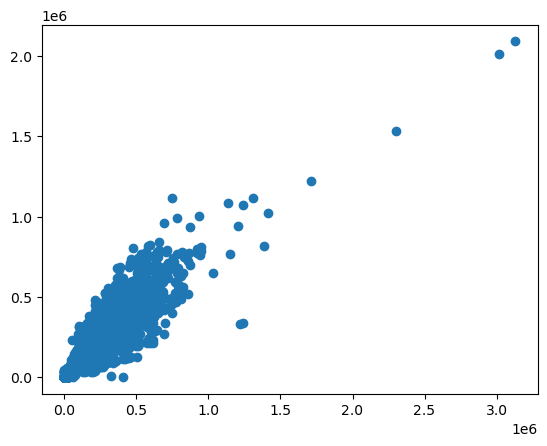

In [9]:
# WFPER | WFPAR

plt.scatter(DB5.WFFORM, DB5.WFPER)

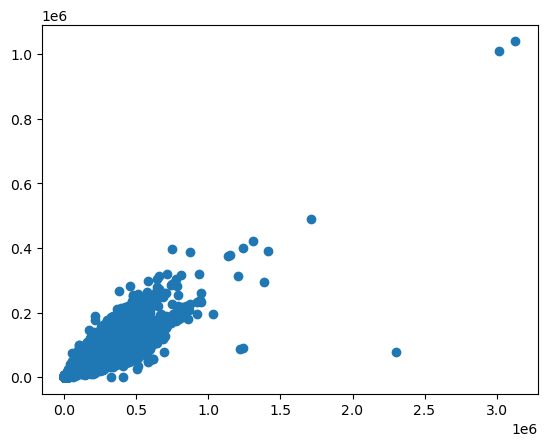

In [10]:
plt.scatter(DB5.WFFORM, DB5.WFPAR)

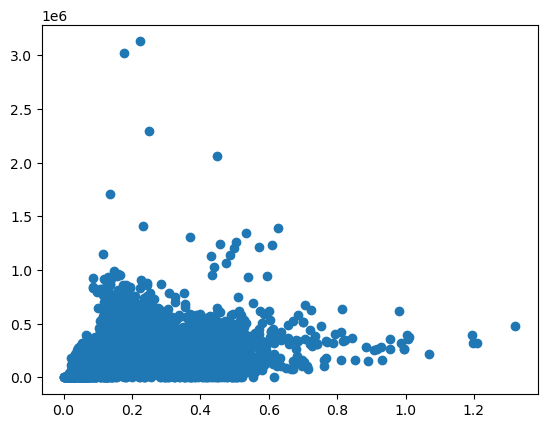

In [8]:
plt.scatter(DB5.TAUTH, DB5.WFFORM)

In [ ]:
raw_DB5.shape

In [ ]:
len(DB5)

# INFORMATION IN THE DATABASE

[Description of Features](https://docs.google.com/document/d/19iVcGGwQGzrTmRmv6QWqR_BRhZhJrsfM/edit?usp=sharing&ouid=108518602132499005107&rtpof=true&sd=true)

IMPORTANT

* For all registers, there is no internal transport barrier registered.
* Not all columns might have the same units even if the represent the same; z.B.: Power. 


**IDEA** Make a note on the TOKAMAKS that use a Limiter and the ones that don't. I think not all Tokamaks have a Divertor as well. Check that. :P 

* Apparently, `TFTR` doesn't have a Divertor; but, it is hard to tell. 

#### NOTE ON HEATING AND DIVERTORS

Obtained from: **ADX: a high field, high power density, advanced divertor and RF tokamak** 

[[B. LaBombard, E. Marmar, J. Irby, T. Rognlien, M.Umansky, 2017]](https://www.osti.gov/pages/biblio/1463827)

<img src="data/Images/ADX: a high field-high power_ICRH.png" class="center" width=600>

In [ ]:
# DWMHD = DWDIA
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"
                         ] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ENBI"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD",]
 # corrections on power loss | NBI Power lost by unconfined orbits
power = ["PLTH","PFLOSS","POHM"]
temperatures = ["TAV","TEV","TIV"]
# e-density in SOL | total due to NBI| total due to ICRH
fast_particles = ["NESOL","WFFORM","WFICFORM"] 

interesting_features = plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power + temperatures + fast_particles

In [ ]:
physical_variables = ["RHOSTAR","BETASTAR","NUSTAR"]
engineering_variables = ["KAREA","EPS","NEL","IP","MEFF","BT","PLTH","RGEO"]

entropy_features = ['RHOSTAR', 'BETASTAR', 'KAREA', 'EPS', 'NEL', 'TAV', 'QCYL5', 'NUSTAR']
research_features = ['TAUTH','NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

In [ ]:
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE",
               "ICSCHEME","AUXHEAT","EVAP"] + TOK_characteristics 

In [ ]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET", "ENBI", "PNBI", "POHM", "PRAD"]
impurities = ["EVAP","ZEFF","ZEFFNEO"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 


features = plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power + temperatures  + fast_particles

len(features)

In [ ]:
sorted(impurities)

In [ ]:
"Acknowledgements".upper()

### TREATMENT TO CATEGORICAL DATA

#### Replacement of NaN to UNKNOWN

In [ ]:
DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

In [ ]:
DB5.TOK.unique()

In [ ]:
DB5["DIVNAME"].unique()

In [ ]:
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)
DB5["DIVNAME"].unique()

In [ ]:
DB5["DIVNAME"].unique()

In [ ]:
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 

In [ ]:
sorted(fast_particles)

In [ ]:
len(fast_particles)

In [ ]:
strrr = "'WFICFORM', 'WFFORM', 'ZEFFNEO', 'DWDIA', 'RHOSTAR', 'POHM', 'BETASTAR', 'NEL', 'WMHD', 'TAV', 'NUSTAR', 'PFLOSS', 'EPS', 'PLTH', 'QCYL5'"

In [ ]:
strrr.replace("'","")

In [ ]:
strrr